CSC14120 – PARALLEL PROGRAMMING: FINAL PROJECT

Group ID: 12

| Họ và tên  | Nguyễn Trương Hoàng Thái  | Trần Quốc Đạt  |
|---|---|---|
| MSSV  | 20127625  | 20127134  |

# Cài đặt và sử dụng
* Mô hình của đồ án được thực thi với `GPU Tesla T4 7.5` của `Google Colab`. Các cấu hình và kết quả kiểm thử được lưu trữ tại file [notebook](https://colab.research.google.com/drive/1H_2zqUGyKyxCmVCGe7rlknMv2mEp3P6c?usp=sharing).
* Cmake đã được cấu hình để có thể biên dịch và thực thi với cả hai phiên bản là host (thực thi tuần tự) và device (thực thi song song) cho quá trình nhân tích chập.
* Với phiên bản device, hiện tại đã có 3 phiên bản filter là filter1, filter2, filter3. Để lựa chọn phiên bản thực thi, truyền vào một trong các tham số 0, 1, 2,... tương ứng với host, filter1, filter 2 ... filter k. Ví dụ `./demo 0 ` = phiên bản host; `./demo 1 ` = phiên bản filter 1.


# Mô tả bài toán
## Input
* Dữ liệu được sử dụng cho đồ án này là tập dữ liệu [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist.git). Fashion-MNIST là bộ dữ liệu gồm 60000 bức ảnh ở tập huấn luyện và 10000 bức ảnh ở tập kiểm thử, tất cả đều là ảnh trắng đen (1 kênh màu). Mỗi bức ảnh ở tập dữ liệu này có kích thước 28x28 pixel và được phân loại bởi 10 lớp khác nhau.
* Fashion-MNIST có cấu trúc tương tự tập dữ liệu gốc là [MNIST](http://yann.lecun.com/exdb/mnist/). Mục đích của bộ dữ liệu Fashion-MNIST là giúp giảm thiểu tình trạng overfitting của các mô hình học máy đối với bộ dữ liệu gốc là MNIST, từ đó đem lại quá trình đánh giá chính xác hơn.
* Ở đồ án này, dữ liệu được cấu trúc và xử lý bởi Eigen `Matrix` theo ma trận cột, trong đó mỗi cột là một ảnh và 28x28 dòng cho mỗi pixel của ảnh tương ứng. Các tầng khác nhau có phương thức foward tương ứng với hành vi của tầng để xử lý dữ liệu đầu vào.

## Output
* Kết quả đầu ra của mô hình mini-dnn-cpp là kết quả phân lớp của dữ liệu đầu vào tương ứng. Nhãn kết quả dự đoán được so sánh với nhãn đúng để tính toán độ chính xác của mô hình. 
* Ở hai tầng convolution C1 và C3, kết quả đầu ra có cấu trúc giống với dữ liệu đầu vào (Eigen `Matrix` theo ma trận cột, mỗi cột là một ảnh và mỗi dòng là một pixel tương ứng) nhưng số lượng dòng của ma trận là bội số theo channel đầu ra (số lượng filter).

## Ứng dụng của đồ án
* Toàn bộ dự án là một mạng CNN (Convolutional Neural Network) với các tầng convolution, max pooling, dense layer và các tầng kích hoạt đem lại khả năng nhận dạng và phân lớp những bức ảnh đầu vào. Các pixel của một bức ảnh được lưu trữ bởi thư viện Eigen và được xử lý bởi mô hình để đạt được nhãn dự đoán thích hợp.

## Tăng tốc khả năng xử lý của mô hình
* Ở phiên bản mặc định, quá trình nhân tích chập ở các tầng convolution (C1, C3) được thực hiện tuần tự cho từng bức ảnh bởi CPU. Điều này không ảnh hưởng đến kết quả phân lớp của mô hình nhưng thời gian thực thi là không hề nhỏ.
* Ý tưởng tăng tốc cho mô hình là song song hóa quá trình nhân tích chập ở hai tầng C1 và C3. Việc nhân tích chập cho mỗi bức ảnh sẽ diễn ra đồng thời và được thực thi bởi GPU, giúp cải thiện đáng kể thời gian thực thi của mô hình.

# Quá trình thực hiện

## 1. Thay đổi mô hình của tác giả thành mô hình gợi ý
Quá trình được thực hiện dựa trên mô hình ban đầu: [mini-dnn-cpp](https://github.com/iamhankai/mini-dnn-cpp.git)

### 1.1 Xác định cấu trúc mã nguồn
THƯ MỤC:
* src
  * layer: cài đặt các tầng convolution, pooling, hàm kích hoạt dựa trên interface ở file layer.h.
  * loss: cài đặt hàm đo độ lỗi (cross entropy, mse).
  * optimizer: cài đặt stochastic gradient descent.
* data: chứa bộ dữ liệu Fashion-MNIST.
* third_party: chứa thư viện eigen hỗ trợ tính toán đại số.
* Report: chứa file báo cáo (ipynb) và các tài liệu liên quan.

TẬP TIN (đa số ở thư mục src):
* mnist: đọc tập dữ liệu mnist. Dữ liệu sẽ được xử lý theo cột: mỗi cột sẽ tương ứng với một ảnh trắng đen (một kênh màu) gồm 28x28 dòng thể hiện cho mỗi pixel.

* layer.h: cài đặt interface cho các tầng convolution, pooling.

* network: cấu tạo của mô hình, chứa các layer và hoạt động của mỗi layer.

* demo.cc: tập tin chính của chương trình, gồm cấu trúc và quá trình huấn luyện mô hình.

MỘT VÀI BIẾN SỐ CỦA CHƯƠNG TRÌNH:
* channel: số kênh của dữ liệu. Nếu tầng convolution có channel_out=3 nghĩa là có 3 neuron (tương ứng 3 kernel) ở tầng này.

* dim (với các tầng khác dense): số lượng pixel của ảnh, có giá trị bằng height x width x channel.

* dim (với dense layer): số lượng neuron của tầng.

* Quá trình nhân tích chập và pooling sẽ làm tròn phần tử lên với trường hợp dữ liệu có số lượng lẻ. Kết quả cuối cùng phụ thuộc vào nhiều yếu tố như stride, padding...


### 1.2 Chỉnh sửa ở file demo.cc:
* Thêm thư viện time.h và 2 đối tượng `time_t`: start + end để đo thời gian thực thi của chương trình (giây).
* Convolutional layer (Conv2D) có filter 5x5, stride = 1x1, padding = 0, số lượng là 6 và 16 tương ứng với tầng C1 và C3.
* Pooling layer (MaxPooling2D) có kích thước là 2x2, stride = 2x2, padding = 0.

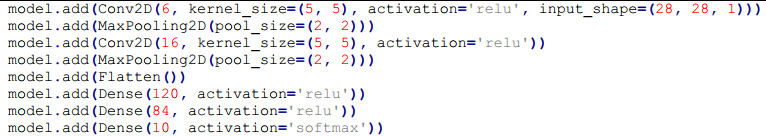

*Cần lưu ý ở file demo.cc trước khi chạy: dataset - model - epoch.*

## 2. Setup cuda và cmake

Ý tưởng ban đầu là đổi file /src/layer/conv.cc thành /src/layer/conv.cu và cài đặt các filter ở đây nhưng không thể tìm ra giải pháp.

### 2.1 Thay đổi compiler của cmake để biên dịch cuda [(tham khảo)](https://dominoc925.blogspot.com/2021/03/creating-simple-cuda-with-cmake-c.html)
* Chỉnh sửa hai dòng ở file /CMakeLists.txt.
* Sửa dòng số 42 ở /third_party/eigen/Eigen/Core: math_functions.h

### 2.2 Cải tiến để chương trình có thể nhận cmd argument (lựa chọn host hoặc device):
* Thêm thuộc tính public `int use_device` ở file /src/network.h và /src/layer.h
* Ở file `demo.cc`: setup giá trị `use_device` cho dnn (sử dụng atoi() vì cuda 12.2 không hỗ trợ stoi()).
* Ý tưởng: network sẽ nhận yêu cầu sử dụng filter (GPU) từ người dùng thông qua cmd với 0 = sử dụng cpu (convolution tuần tự), k (k > 0) = filter loại k. Phương thức forward của network sẽ setup `use_device` cho các layer. Giá trị `use_device` chỉ được sử dụng ở file `conv.cc` để lựa chọn filter.

## 3. Sử dụng eigen với cuda và cmake

* Chỉnh sửa 3 file: filter.h, filter.cu, conv.cc (ở đường dẫn `/src/layer/`).
* Truyền dữ liệu từ file conv.cc (Matrix) sang file filter.cu: sử dụng con trỏ `float*` để lưu trữ dữ liệu dưới dạng column-major (dạng mặc định của eigen). Để kiểm tra quá trình truyền dữ liệu, có thể in ra từng phần tử của con trỏ (không sử dụng sizeof() vì sẽ làm hủy chương trình. Chưa tìm ra nguyên nhân cho trường hợp này).
* Thêm `#ifndef USE_CUDA` + `#endif` ở file filter.cu.

## 4. Thực thi với cuda filter
* Cài đặt filter 1.
* Cài đặt filter 2.
* Cài đặt filter 3.


# Mô tả tuần tự
## Thiết kế
* Các bức ảnh đầu vào được lưu trữ bởi ma trận hai chiều với mỗi dòng là một pixel của channel tương ứng và mỗi cột là một bức ảnh. Ví dụ với tầng C1, dữ liệu huấn luyện có kích thước (28x28, 60000); với tầng C3, dữ liệu huấn luyện là đầu ra của tầng max pooling trước đó với kích thước (12x12x6, 60000).
* Để đạt được sự hiệu quả, dữ liệu sẽ được huấn luyện theo phương thức mini-batch. Mỗi batch có kích thước là 128 ảnh với tổng cộng 5 epoch cho toàn bộ quá trình và sau mỗi epoch, kết quả đánh giá mô hình dựa trên bộ nhãn đúng của tập kiểm thử được in ra màn hình. 
* Quá trình nhân tích chập sẽ diễn ra tuần tự cho từng bức ảnh (từng cột của ma trận) với quy trình: rút trích dữ liệu từ ma trận, nhân với trọng số của filter, cộng bias.

## Đánh giá kết quả
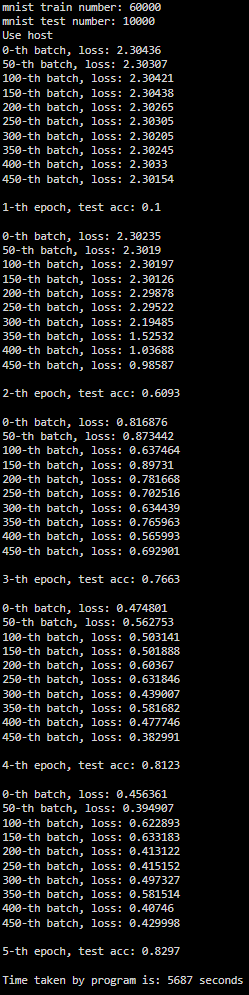

* Thời gian để mô hình phân lớp và đánh giá tập dữ liệu Fashion-MNIST là `5687` giây, với độ chính xác sau epoch thứ 5 là `82.97%`.
* Kết quả dự đoán của mô hình là kết quả đúng trên tập dữ liệu hiện tại. So sánh với kết quả khi thực thi trên tập dữ liệu MNIST là `98%+`, Fashion-MNIST đã cho thấy sự hiệu quả khi hạn chế được tình trạng overfitting của mô hình với kết quả rõ rệt (chênh lệch ~15%).

# Mô tả song song


## Filter 1

### Phân tích
* Cài đặt song song sẽ được thực hiện cho quá trình nhân tích chập ở tầng C1 và C3. Nhân tích chập là quá trình khá đơn giản vì chỉ gồm hai phép toán là cộng và nhân nhưng số lượng phép tính là rất lớn. Việc sử dụng các nhân của GPU để song song hóa quá trình nhân tích chập là hoàn toàn phù hợp để tăng tốc độ xử lý của mô hình.
* Để cài đặt một phiên bản song song, quá trình phân tích được thực hiện dựa trên quy trình sau:
    1. Phân tích input (tên biến, vị trí của biến, kích thước cụ thể),
    2. Phân tích output.
    3. Phân tích filter.
    4. Truyền dữ liệu cho device.
    5. Xây dựng đồ hình của device và tính toán.

1. Input
* Ở tầng C1 và C3: dữ liệu đầu vào là ma trận `bottom` ở file `/src/layer/conv.cc`. Ma trận gồm các ảnh trắng đen (có 1 kênh màu) được cấu trúc và xử lý theo ma trận cột, trong đó mỗi cột là một ảnh và mỗi dòng là mỗi pixel của ảnh tương ứng.
* Tầng C1: `bottom` có kích thước (28x28, 60000).
* Tầng C3: `bottom` có kích thước (12x12x6, 60000), là dữ liệu đầu ra ở tầng P2 sau khi đã pooling.
2. Output
* Ở tầng C1 và C3: dữ liệu đầu ra là ma trận `top`. Ma trận gồm các ảnh trắng đen (có 1 kênh màu) được cấu trúc và xử lý theo ma trận cột, trong đó mỗi cột là một ảnh và mỗi dòng là mỗi pixel của ảnh tương ứng.
* Tầng C1: `top` có kích thước (24x24x6, 60000), với 6 là số lượng filter.
* Tầng C3: `top` có kích thước (8x8x16, 60000), với 16 là số lượng filter.
3. Filter
* filter là ma trận `weight` có kích thước (channel_in * h_kernel * w_kernel, channel_out). (từ file /src/layer/conv.cc)
4. Bias
* bias cho quá trình forward là vector `bias` có kích thước (channel_out). (từ file /src/layer/conv.cc)

*Tất cả dữ liệu đều có kiểu dữ liệu là float.*

### Thiết kế
* Mỗi thread sẽ thực hiện nhân tích chập cho một pixel tương ứng ở kết quả đầu ra. Đồ hình của device sẽ được xây dựng với block 2D và grid 3D, với:
    * Mỗi thread blocks được chia nhỏ với kích thước TILE_WIDTH x TILE_WIDTH cho mỗi filter ở đầu ra. Ví dụ, nếu TILE_WIDTH = 8 thì mỗi block sẽ có 64 threads.
    * Thread blocks được tổ chức với các grid 3D, trong đó:
        1. Chiều đầu tiên (chiều X) là số lượng bức ảnh của dữ liệu đầu ra.
        2. Chiều thứ hai (chiều Y) là số lượng filter (output features maps).
        3. Chiều thứ ba (chiều Z) là vị trí của thread ở pixel tương ứng trong dữ liệu đầu ra.
    * Giá trị của chiều Z trong grid sẽ phụ thuộc vào kích thước dữ liệu đầu ra, cụ thể:

    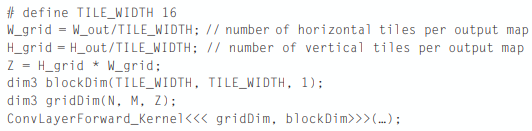

* Với mô hình hiện tại, giá trị `TILE_WIDTH` được chọn là 8 vì đây là GCD(24, 8) với 24 và 8 lần lượt là kích thước đầu ra của dữ liệu ở tầng C1 và C3.

* Giới hạn của GPU tesla 7.5 trên Google Colab có thể đáp ứng được ý tưởng của filter 1, với kích thước cài đặt:
    * blockSize(8, 8, 1).
    * gridSize (128, 6, 9) và (128, 16, 1) tương ứng với C1 và C3.

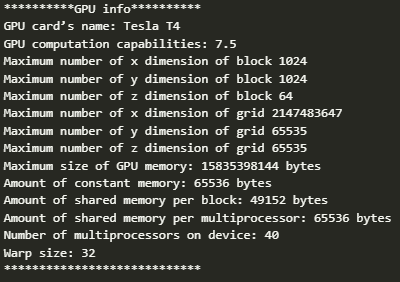


### Cài đặt
* Với thiết kế mỗi thread tính toán cho mội pixel tương ứng ở dữ liệu đầu ra và dữ liệu được lưu trữ dưới dạng mảng một chiều `float*`, quá trình cài đặt được minh họa bằng bản viết tay sau:

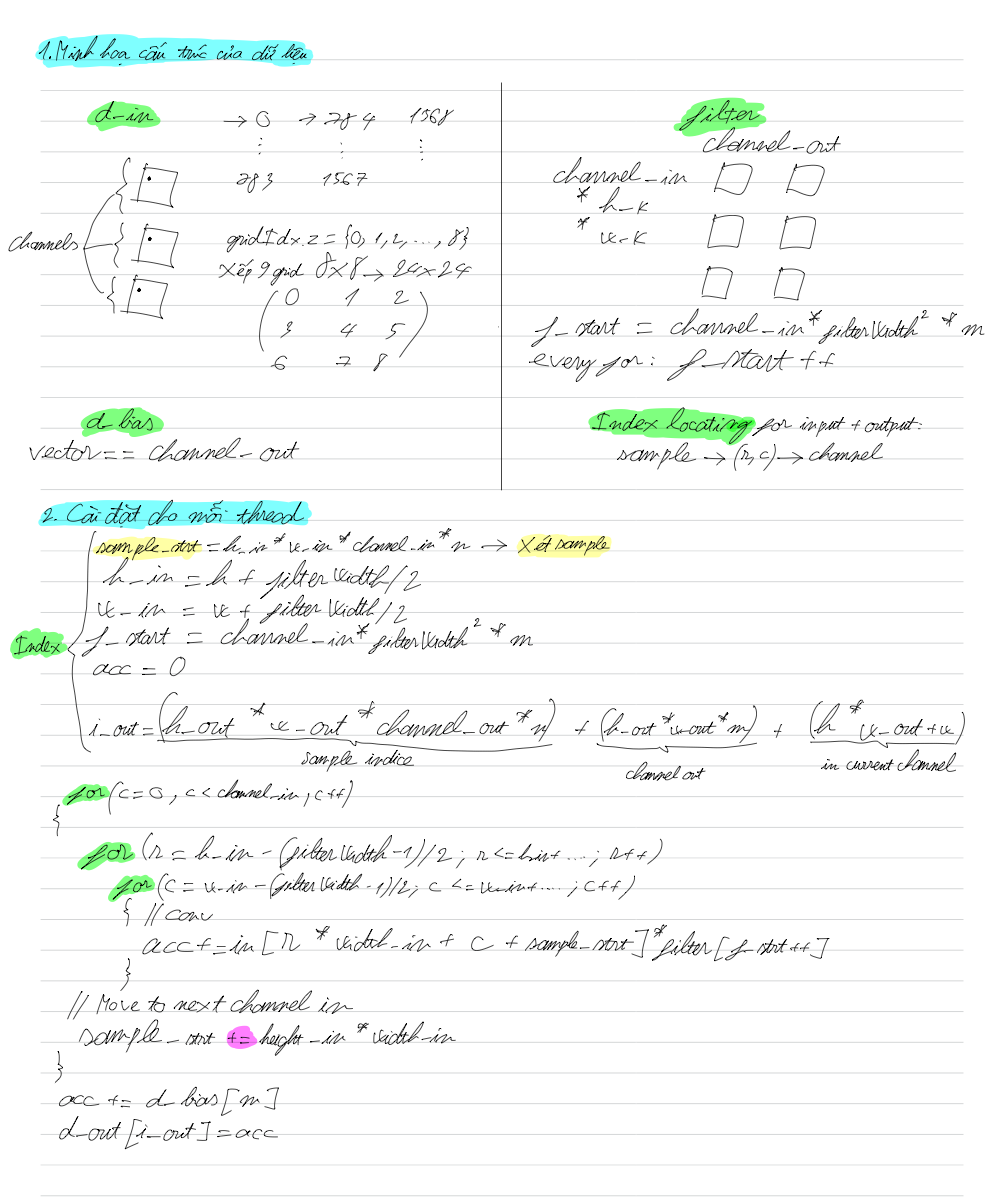


### Đánh giá kết quả

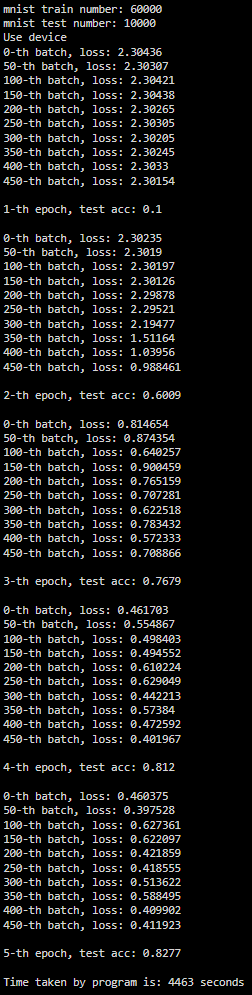

* Phương pháp song song hóa quá trình nhân tích chập ở hai tầng C1 và C3 đã thể hiện rõ kết quả tối ưu thời gian thực thi của chương trình: 4463 giây so với 5687 giây của phiên bản tuần tự. Kết quả này giúp chương trình thực thi nhanh hơn 1224 giây (~20 phút) với độ chính xác gần như là không thay đổi.

## Filter 2

### Thiết kế
* Sử dụng SMEM giúp giảm thời gian truy xuất dữ liệu đầu vào ở GMEM:
1. Mỗi thread trong cùng 1 block sẽ copy dữ liệu từ GMEM sang SMEM. Quá trình này được chia thành các bước như sau:
    1. Đối với tất cả thread trong cùng block: copy phần tử từ GMEM tương ứng vào SMEM.
    2. Với các thread ở biên sẽ được chia thành 4 loại: biên `trên cùng`, biên `dưới cùng`, biên `bên trái`, biên `bên phải`. Phần cài đặt có thể sử dụng câu lệnh rẽ nhánh với điều kiện là các threadIdx để chọn ra các phần tử ở biên. Các thread ở biên sẽ copy filterWidth/2 phần tử theo đường thẳng, cụ thể như sau:
      * Thread ở biên trên cùng sẽ copy phần tử có chỉ số [r’][c], với r’ = r - filterWidth/2 (r’ tăng dần với điều kiện r’ < r vì phần tử có chỉ số dòng r đã copy ở bước đầu).
        * Ở vị trí biên trên cùng sẽ có hai thread đặc biệt là thread ở góc trái và thread ở góc phải. Hai thread này ngoài việc copy dữ liệu theo đường thẳng còn phải copy dữ liệu theo hướng chéo. Trong phần cài đặt sẽ copy từ phần tử ở dòng trên cùng xuống dần. Với mỗi dòng sẽ copy phần tử từ góc ngoài cùng (phần tử phải cùng với thread ở góc phải và phần tử trái cùng với thread ở góc trái).
      * Thread ở biên dưới cùng sẽ copy phần tử có chỉ số [r’][c], với r’ = r + filterWidth/2 (r’ giảm dần với điều kiện r’ > r vì phần tử có chỉ số dòng r đã copy ở bước đầu).
        * Ở vị trí biên dưới cùng sẽ có hai thread đặc biệt là thread ở góc trái và thread ở góc phải. Hai thread này ngoài việc copy dữ liệu theo đường thẳng còn phải copy dữ liệu theo hướng chéo. Trong phần cài đặt sẽ copy từ phần tử ở dòng dưới cùng lên dần. Với mỗi dòng sẽ copy phần tử từ góc ngoài cùng.
      * Thread ở biên bên trái sẽ copy phần tử có chỉ số [r][c’], với c’ = c - filterWidth/2 (c’ tăng dần với điều kiện c’ < c vì phần tử có chỉ số cột c đã copy ở bước đầu).
      * Thread ở biên bên phải sẽ copy phần tử có chỉ số [r][c’], với c’ = c + filterWidth/2 (c’ giảm dần với điều kiện c’ > c vì phần tử có chỉ số cột c đã copy ở bước đầu).
    3. Điều kiện cho r’ (r’ < 0 hoặc r’ >= height) và c’ (c’ < 0 hoặc c’ >= width) sẽ được xử lý bằng cách lấy phần tử giả theo quy ước của lab 1.

Sử dụng `__syncthreads()` để đồng bộ quá trình copy dữ liệu của các thread trong cùng block. Sau khi tất cả thread đã hoàn thành quá trình copy dữ liệu, mỗi thread sẽ tính toán với các dữ liệu tương ứng ở SMEM và filter. Dưới đây là hình minh họa được chỉnh sửa dựa trên gợi ý của thầy cho ý tưởng trên. Những thread được chấm tròn sẽ copy dữ liệu từ các phần tử được đánh dấu X cùng màu. Bốn thread ở bốn góc sẽ phải copy thêm những phần tử theo hướng chéo:

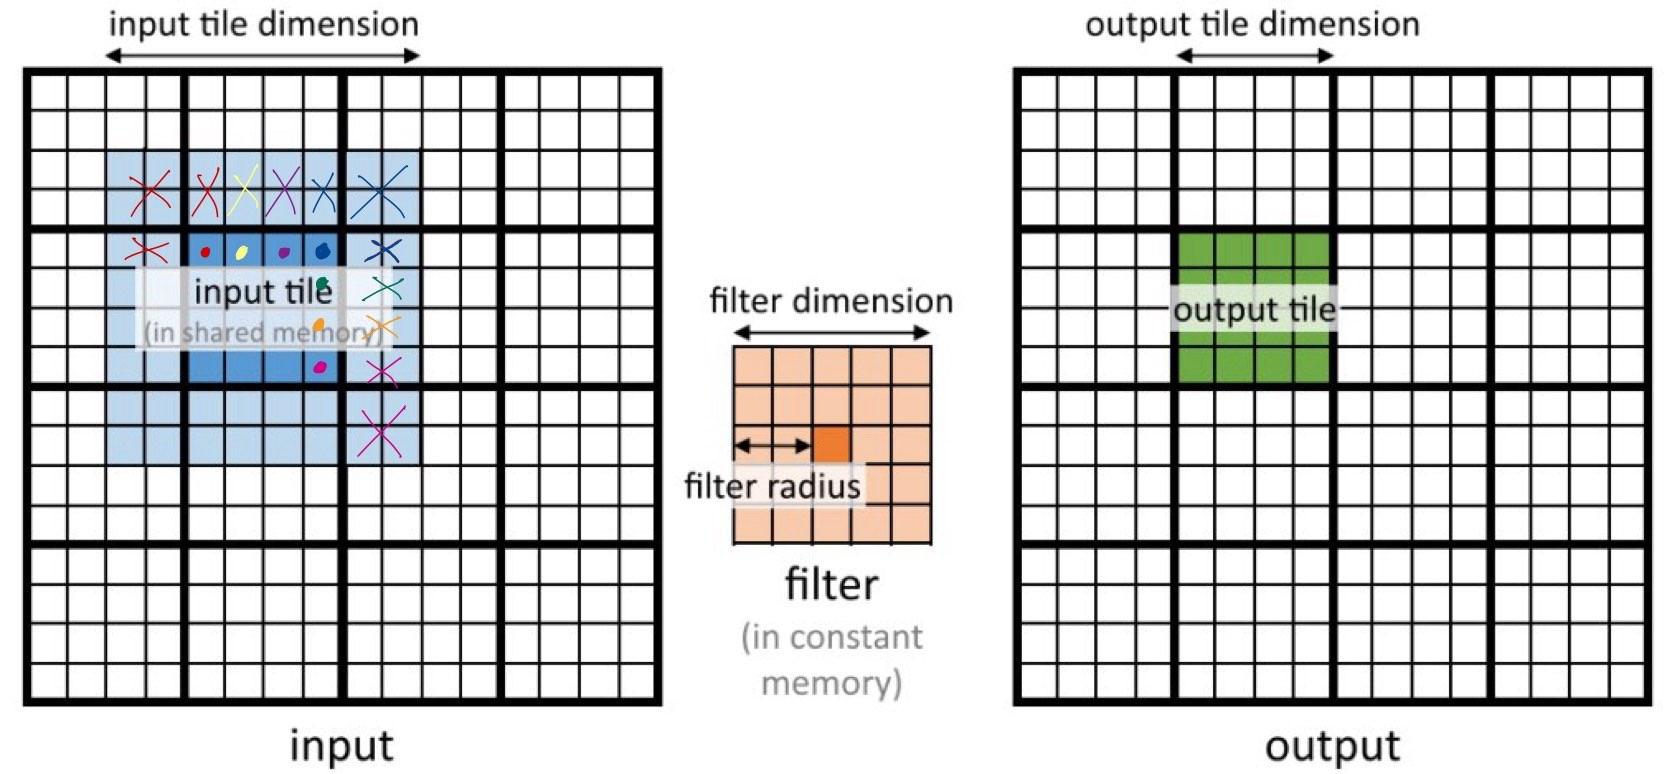

2. Mỗi thread sẽ thực hiện nhân tích chập cho một pixel tương ứng ở kết quả đầu ra. Đồ hình của device sẽ được xây dựng với block 2D và grid 3D, với:
* Mỗi thread blocks được chia nhỏ với kích thước TILE_WIDTH x TILE_WIDTH cho mỗi filter ở đầu ra. Ví dụ, nếu TILE_WIDTH = 8 thì mỗi block sẽ có 64 threads.
* Thread blocks được tổ chức với các grid 3D, trong đó:
    1. Chiều đầu tiên (chiều X) là số lượng bức ảnh của dữ liệu đầu ra.
    2. Chiều thứ hai (chiều Y) là số lượng filter (output features maps).
    3. Chiều thứ ba (chiều Z) là vị trí của thread ở pixel tương ứng trong dữ liệu đầu ra.
* Giá trị của chiều Z trong grid sẽ phụ thuộc vào kích thước dữ liệu đầu ra, cụ thể:

    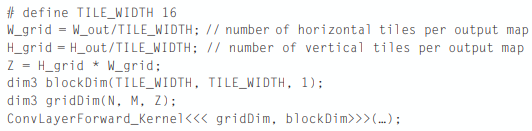

* Với mô hình hiện tại, giá trị `TILE_WIDTH` được chọn là 8 vì đây là GCD(24, 8) với 24 và 8 lần lượt là kích thước đầu ra của dữ liệu ở tầng C1 và C3.

### Đánh giá kết quả

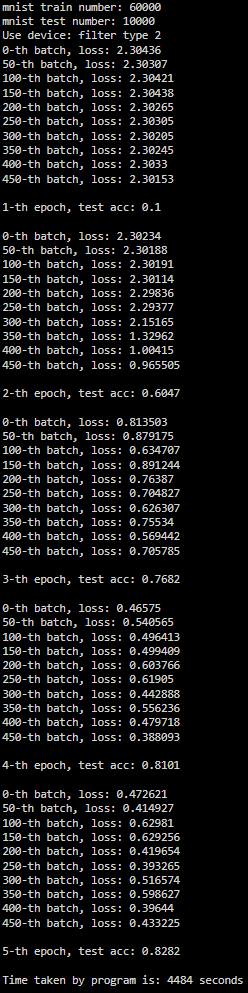

* Việc sử dụng SMEM ở filter 2 giảm được đáng kể số lần (thời gian truy xuất) vào GMEM của các thread. Mỗi thread trong cùng block sẽ chỉ copy dữ liệu tương ứng với chỉ số threadIdx của mình mà không có phần tử nào ở GMEM bị copy bởi hai thread khác nhau.
* Tuy ý tưởng này là khá phù hợp (giảm thời gian truy xuất GMEM, không copy trùng phần tử ở GMEM...) nhưng có một vấn đề đối với các thread ở biên `trên cùng` và biên `dưới cùng` đó là việc truy xuất GMEM không liên tục (uncoalesce) trong quá trình copy dữ liệu sang SMEM.
* Trong phiên bản Colab 7.5, vùng nhớ GMEM ở device được chia thành các sector. Mỗi sector có kích thước là 32 bytes liên tiếp nhau và 4 sector liên tiếp tạo thành một cache line. Dữ liệu ở vùng nhớ GMEM được truyền tải theo đơn vị sector, điều này nghĩa là nếu chương trình chỉ sử dụng 1 byte thì vẫn phải load đủ 32 bytes.
* Việc truy xuất GMEM không liên tục trên một tập dữ liệu lớn dẫn đến kết quả của filter 2 còn có phần tệ hơn so với filter 1 với 4484 giây thực thi.

## Filter 3

### Thiết kế
* Thiết kế của filter 3 tương tự với filter 2 nhưng ở phiên bản này, trọng số của filter sẽ được lưu trữ ở constant memory (CMEM) với kỳ vọng giảm thời gian truy xuất vào GMEM.

### Đánh giá kết quả

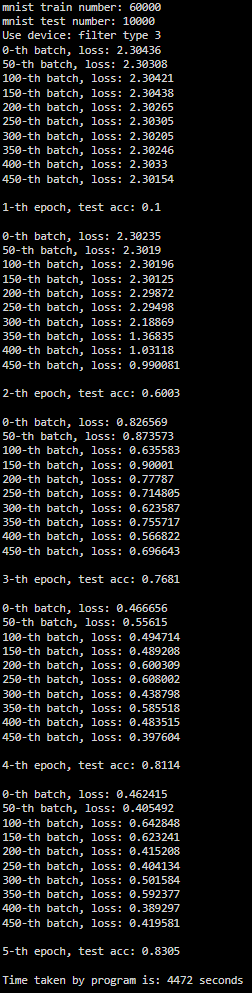


# KẾ HOẠCH THỰC HIỆN
20-26/11: tìm hiểu về cnn, LeNet-5, setup và chạy mã nguồn mini-dnn-cpp với bộ dữ liệu mnist.

27/11 - 03/12: tìm hiểu mã nguồn mini-dnn-cpp, thay đổi mô hình với cấu trúc LeNet-5 (được tinh chỉnh theo yêu cầu của đồ án) và chạy mô hình trên tập dữ liệu fashion MNIST.

08/12 - 27/12: cài đặt GPU Convolution kernel cơ bản.

28/12 - 30/12: tối ưu GPU Convolution kernel, viết báo cáo.

31/12: quay video trình bày đồ án.

# NGUỒN THAM KHẢO
[1] BASE MODEL: mini-dnn-cpp
* https://github.com/iamhankai/mini-dnn-cpp.git

[2] DATASET: fashion MNIST
* https://github.com/zalandoresearch/fashion-mnist

[3] RELATED KNOWLEDGE: CNN + LeNet-5
* https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide/notebook
* https://setosa.io/ev/image-kernels/
* https://poloclub.github.io/cnn-explainer/
* https://www.tensorflow.org/

[4] Convert Eigen Matrix to C array
* https://stackoverflow.com/questions/8443102/convert-eigen-matrix-to-c-array
* [How to work with Eigen in CUDA kernels](https://stackoverflow.com/questions/23802209/how-to-work-with-eigen-in-cuda-kernels)

[5] [Book](https://rd.yyrcd.com/Books/2022-03-15-Programming%20Massively%20Parallel%20Processors%203rd%20Edition.pdf): Programming Massively Parallel Processors (Third Edition)
* Chapter 16 (slide 362): CONVOLUTIONAL LAYER: A BASIC CUDA IMPLEMENTATION OF FORWARD PROPAGATION

[6] Lab 1 & Lab 3 of course assignment.